# Notes, 1/3/18
* ODB website: https://software.ecmwf.int/wiki/display/ODBAPI/ODB+API+Home
* ODB API is a software developed at ECMWF for encoding and processing of observational data. It includes a SQL filtering and statistics engine, command line tools and APIs for C/C++, Fortran and Python. ODB API works with data format used in ECMWF observational feedback archive. Development of ODB API has been partially funded by the Met Office.
    * C/C++ base with Fortran and Python wrappers
* ODB examples seem to indicate that the API
    * Is for general SQL table creation and access
    * Tables have heterogeneous data in columns going across a row
        * Cumbersome to accees in C/C++/Fortran
        * Not so bad in Python (example uses pandas which makes this easy)
* ODB provides a command line tool called "odb"
    * SQL access, plotting tools, inspect/compare odb files
    * This seems more oriented toward observation data
* ODB files follow a convention for metadata
    * ODB Governance (?)

## Download and Install
* Download: https://software.ecmwf.int/wiki/display/ODBAPI/Releases
* Install instructions: https://software.ecmwf.int/wiki/display/ODBAPI/ODB+API+Installation
    * Build and install appear to work
        * Sample program in install/bin directory: odbql_c_example 
            * creates an odb file without error
            * "odb ls odb_file" shows its contents
    * Test works, but 4 tests fail
        * Output from ctest:
        
            > 99% tests passed, 4 tests failed out of 333  
            >
            > Label Time Summary:  
            > download_data     =   1.43 sec (6 tests)  
            > eckit             =  80.20 sec (96 tests)  
            > executable        =  82.10 sec (103 tests)  
            > metkit            =   0.46 sec (3 tests)  
            > mpi               =   6.66 sec (2 tests)  
            > odb_api           = 144.56 sec (234 tests)  
            > odb_api_ecml      =  56.02 sec (27 tests)  
            > odb_api_netcdf    =   0.56 sec (2 tests)  
            > script            = 141.70 sec (224 tests)  
            >
            > Total Test time (real) = 226.30 sec 
            >
            > The following tests FAILED:  
            >     41 - eckit_test_mpi (Failed)  
            >     42 - eckit_test_mpi_addcomm (Failed)  
            >     95 - ECKIT-221.sh (Failed)  
            >     96 - ECKIT-166.sh (Failed)  
            > Errors while running CTest  

    * The example program worked, so not sure what is broken.

        

# Meeting with Yannick, 1/5/18
* The ODB file is probably an SQL file
    * Developers likely took an open source API for SQL and wired it into ODB
* Are there templates for obs type tables in SQL?
    * I was looking for the C/C++/Fortran APIs to have something like pandas in Python
    * Yannick said that the tendancy is to design a table once, when a new instrument appears, then use that code over and over
        * The creation of a new table occurs very infrequently
        * Proablay not worth the effort to provide a generic table capability like pandas
* The 4 test failures are probably okay for now
    * MPI test failures may be indicating that I don't have MPI installed/enabled on my iMac
* We will potentially collaborate with ECMWF on development
    * Yannick will talk with people at AMS next week
    * Depending on how these talks go
        * Might get someone from ECMWF to come out here for a week or so to train us
        * Or, might go to ECMWF for their annual training session
* Use the website and code repository for help with API, examples, etc.
    * If this doesn't work well, perhaps the training will happen

# UKMO visit, 6/27/18 - 7/3/18

## Overview of ODB

* ECMWF wiki: https://software.ecmwf.int/wiki/display/ODBAPI/ODB+API+Home

* 0.18.0 is latest version

* Two versions of database
    * ODB1 - "ODB"
    * ODB2 - "ODB API"

* Go to ODBAPI home (link above) and download the tar file
    * CMake based
    * "odb" directory has code for ODB1
    * "odb_api" directory has code for ODB2
    * "odb-tools" directory has utilities (odbsql for browsing contents of odb files)

* ODB1 has Fortran interface

* ODB2 has Fortran, C++ and Python interfaces

* Not a lot of documentation

* ODB has a standard interface that is SQL-like (sqlite3)
    * Iterator based

* ODB data is organized into tables
    * A "row" is a single record that you can pull out of the database
    * There is a way to configure the tables (very flexible)
    * Typically you place one observation value in each row (t, q, u, or v)
        * A row contains all metadata associated with that obs value (error, qc, a_minus_b, etc)

* Parallelism
    * Only supported in ODB1
        * However, you could do your own parallelism outside of ODB2
        * Eg, split up obs into a set of ODB2 files, then handle communication via MPI
    * For ODB1 Data is organized into "pools"
        * Each process handles a pool
        * The schema (below) takes care of keeping things like all channels at a single location together
        
        * Many files on the file system for holding pools
            * Get a set of subdirectories named '1', '2', '3', etc
            * Underneath '1' (and others) get more subdirectories
                * schema, data, etc.
            
            * Can get large number of files
                * 1000's of pools ==> 10,000's files
                * Performace issue
                    * Related to C stat calls
                    
                    * IO methods exist to help with this
                        * Method 1 --> one set of files per pool (default, many files)
                        * Method 4 --> one set of files for n pools (retains the pool division)
        * Note that obs data gets assigned to each MPI process in a round robin fashion
            * On a pool basis
            * Not so great for model partitioning
                * Local clumps of obs could get many obs locations outside model subdomain which requires communication with other model subdomains, thus greatly increasing MPI communication.

* Load balancing
    * Met Office handles this by making the obs filtering (QC, time window, etc.) step separate from the DA step
        * That way, the number of obs gets pared down and load imbalances are not as severe
        * Also, DA step does not deal with ODB
        
    * Met Office software package for filtering is called OPS
        * OPS -> Observation Processing System

* MARS stands for Met_office Archive Retrieval System

### ODB1 Schema

* You predefine the schema
    * Edit a description file (.ddl)
    * Translate to C code
    * Compile (means you have a static table during execution)
    
    * Downside of this is that you have to put in slots to cover metadata for all obs types (wasteful)
        * You could define a schema per obs type
    
* The schema consists of tables where parent tables can point to child tables
    * Totally flexible, you could have many levels of hierarchy if you desired
    
* Typical table organization is to use two or three levels
    * Header - contains information about the file, when it was created, when the obs were recorded, etc.
    * Desc - "description" metadata for the observations, station/satellite id, lat lon for channels, etc.
    * Body - Observation values, plus error values, QC values, etc.
    
* Can use integers, reals, and bitfields
    * Bitfields are for flags, interface takes care of masking, in code can reference these by name
    
* Parameters/Constants/Defines (only for ODB1)
    
* SQL like queries
    
* "NULL" is a special parameter - can set this in ODB1 (but not in ODB2)

* Combining multiple ODB1 files is tricky
    * Create pools, put together into one set, there are scripts supplied to help with this

* Table-based hierarchy in ODB1:

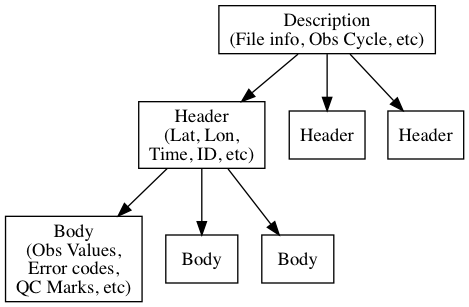

* The link syntax inside DLL schema file
    * This example repesents typical organization for an ODB1 schema
    * @Header --> Header.len, Header.offset
    * Header becomes a large table
        * Row 1 --> Lat for Radiosonde
        * Row 2 --> Lon for Radiosonde
        * Row 3 --> Time for Radisonde
        * Row 4 --> link to Radiosond Body table
        * Row 5 --> Lat for Aircraft
        * Row 6 --> Lon for Aircraft
        * Row 7 --> Time for Aircraft
        * Row 8 --> link to Aircraft Body table
        
        * With this scenario the first link of Header will hold Radiosonde data
            * Header.len = 4
            * Header.offset = 0
        * Second link to Header will hold Aircraft data
            * Header.len = 4
            * Header.offset = 0
        * So, .len and .offset define a particular section in a single large Header table that holds multiple obs types
        
        * In this example
           * Description holds metadata about the file
               * Cycle time
               * File source
               * Etc
           * Header holds BUFR message level data
               * Lat
               * Lon
               * Time
               * Etc
           * Body holds BUFR subset level data
               * Obs values
               * Obs errors
               * Obs qc marks
               * Etc
    
    
### ODB2 Schema

* Format is one file (instead of a set of files)

* No precompile step
    * Column names and types are defined the same way as in ODB1

* Effectively, a single table
    * Lats, Lons duplicated
    * One row is still on obs value
    * Takes more space, but file is compressed

* Optimized for archiving
    * As opposed to ODB1 which is optimized for operations
    * No MPI
    * But could create multiple ODB2 files and dole them out to multiple processes
    
    * Handling MPI outside of ODB could make it possible to separate the reading of obs data from the filtering step
        * Netcdf, ODB --> Read --> ODB --> Filter --> ODB
    
    * Brings up question of where to apply MPI
        * Rely on ODB1 MPI, or create many ODB files and do MPI outside of ODB

* Combining multiple ODB2 files is easy
    * Simply cat them together

* ODB2 has just one giant table (no link syntax)
    * Lat, Lon get repeated
    * Not as space efficient as ODB1, but ODB2 adds in compression so it's not quite as bad as it seems

### Naming conventions

* Does not use netcdf CF names

* ECMWF defined a naming convention
    * ODB Governance
        * Body that defines naming conventions, among other things
        * Following this would help with compatibility with ECMWF tools
    * Could use netcdf CF as well
    
    
### IODA-ODB code

* Simple schema (.ddl file)
    * seqno
        * sequence number
        * need to be unique values, but nice to use 1 through n
    * entryno
        * entry number
        * Unique across a table row
    * Example: Satellite
        * 10 locations, 15 channels (150 obs)
        * seqno goes 1 - 10
        * entryno goes 1 - 15
    * Associations
        * Eg, profiles, channels, flight tracks, etc.
        * Store individual points and rebuild association vs. build in associations (dims on n-dim array)

* Script to do the precompile step
    * Commands are placed in the CMakeLists.txt files to do this step
    * Creates C files and puts them into the build

* Don't have the queries yet

* Source files
    * ObsSpace.odb.interface.F90
    * ioda_obs_odb_mod.F90

* Branches in the UFO and IODA repos
    * odb-support (ODB1)
    * odb-api-support (ODB2)
    * odb-support-single-file (both ODB1 and ODB2)

* Radiosonde example only
    * Converted netcdf to ODB1 and ODB2
    * Note that in the tables, the column size always goes from zero to num_columns
        * 0-th column (extra) is for metadata that ODB code uses

* ODB has a flush cache method (but not being used currently since it isn't working properly)
    * Issue if reading a bunch of files since the entire contents of all files gets read into memory
    * OPS handles this by processing one BUFR file at a time which limits the memory (cache) size

* Current schema is memory intensive
    * One schema with enough columns to cover all obs types
        * This gets allocated up front
    * Alternative would be to have different schemas for each obs type

* ECMWF uses ODB files in two places
    * "ecma" -> one schema, covers many obs types, memory hungry
    * "ccma" -> after QC filtering
    
    * OPS only uses an ecma-like schema since it does not pass ODB to the DA step
        * Started with ecma but had to modify since ECMWF development didn't go where Met Office needed

* Utilities
    * netcdf_to_odb.F90 (ODB1)
        * Can assemble blocks of data, then write to ODB1
    * netcdf_to_odb2.F90
        * No block creation, instead do row by row insertion

* Organization of code (issues, concerns)
    * Obsdb class structure
        * 1: Satellite example
            * Satellite beams hit the Earth and cover an area.
            * So is a Locations object that contains Lat, Lon, Time sufficient for this type of intrument?
            * If not, does this bring up the need to have obs type subclasses for obsdb?

        * 2: Do we want obs file (nc, odb, cvs, etc) to be subclasses for obsdb?
        
        * If we want 1 and 2, this could be an immense number of subclasses which is unworkable
   
    * How does AMSU-A obs op work
        * CRTM would need a volume of teh model space that the beam intersects
        * Does the volume of model space need to be returned in a GeoVaLs object?
    
        * How does IODA interface get impacted by this?
        
        * How do different obs types (satellite, radar, etc) want to access obs data?

* Sample code
    * ioda_obsdb_odb2sonde_mod.F90
        * obsdb_getvars()
            * select case(vname)
                * case("Latitude")
                    * call get_vars(self%filename, ["lat"], "entryno=1", field2d)
                        2nd arg: list of columns to extract from ODB
                        3rd arg: sql query (all records with entryno == 1)
                        
                        Notes:
                          Opens and reads file for every call
                          Specific to every obs type (trying to move away from this)
                          Makes 2 passes through file on each call
                              First to get size of result
                              Second to read data
                              
    * odb_helper_mod.F90
        * get_vars(filname, columns, filter, data)
            * call create_query_sql(columns, filename, filter, query)  
                construct a query in SQL syntax -> goes into 'query' argument  
                "select &lt;var1&gt;,&lt;var2&gt;,... from &lt;filename&gt; where &lt;filter&gt;"
            * call count_query_resutls(filename, query, num_results)
                fetch the size of query results
            * allocate(data(num_columns, num_results)
            * call ... !to load data
        
        * prepare_v2_create()
            creates a "statement" structure (variable "stmt" in code
        
        * typical method is to iterate over rows in the ODB table(s)

* Sample ODB1 shema
    * netcdf_to_odb.F90 example
    * Desc Table (one per file)
    
| Schema Entry | Schema Value   | Code Variable/Value |
|:-------------|---------------:|:-------------------:|
| andate       | YYYYMMDD       | 20160308            |
| antime       | HHMMSS         | 1200                |
| hdr          | @LINK (offset) | 0                   |
| hdr          |       (length) | size(latitudes)     |

    * Hdr Table (one row per observation, length is nobs rows)
    
| Schema Entry | Schema Value   | Code Variable/Value |
|:-------------|---------------:|:-------------------:|
| seqno        | pk1int         | iob                 |
| date         | YYYYMMDD       | dates(iob)          |
| time         | HHMMSS         | times(iob)          |
| lat          | pk9real        | latitudes(iob)      |
| lon          | pk9real        | longitudes(iob)     |
| body         | @LINK (offset) | iob-1               |
| body         |       (length) | 1                   |

    * Body Table (one per observation, length = 1 row)

| Schema Entry | Schema Value   | Code Variable/Value |
|:-------------|---------------:|:-------------------:|
| varno        | pk1int         | 2                   |
| obsvalue     | pk9real        | observations(iob)   |
| entryno      | pk1int         | 1                   |
| vertco_reference_1 | pk9real  | pressures(iob)      |

    * Note all obs have "entryno == 1"
    * The SQL filter "entryno = 1" will select all obs values

* Sample ODB2 schema
    * netcdf_to_odb2.F90 example

| Schema Table Column Name | Code Variable/Value |
|:-------------------------|:-------------------:|
| seqno                    | iob                 |
| lat                      | latitudes(iob)      |
| lon                      | longitudes(iob)     |
| entryno                  | 1                   |
| date                     | dates(iob)          |
| time                     | times(iob)          |
| varno                    | 2                   |
| vertco_reference_1       | pressures(iob)      |
| obsvalue                 | observations(iob)   |

    * Same associations as ODB1 case, but note that date, time, lat, lon get repeated

* The sample schema shown above are specific to Radiosonde

* Utilities
    * In the path ioda/src/odb_api/
        * netcdf_to_odb.F90 - converter from nc to ODB1
        * netcdf_to_odb2.F90 - converter from nc to ODB2
        
        * These two converters are specific to Radiosonde
                          
        
## Build ODB

### Build ODB bundle from snapshot in the tar file

* Go to the ECMWF website (https://software.ecmwf.int/wiki/display/ODBAPI/ODB+API+Home) and download the tar file
    * David has been using 0.17.0 and the latest is 0.18.0 (either should be fine)

* ODB needs another package called eccodes
    * Download from: https://software.ecmwf.int/wiki/display/ECC/Releases
    * Get version 2.8.0

~~~~~~~~
cd $HOME/project
mkdir odb-bundle
cd odb-bundle
tar xzvf odb_api_bundle-0.18.0-Source.tar.gz
tar xzvf eccodes-2.8.0-Source.tar.gz

# build and install eccodes first
cd eccodes-2.8.0-Source
mkdir build
cd build
cmake -DCMAKE_INSTALL_PREFIX=$HOME/projects/odb-bundle/install ..
make -j4
ctest
   # Get a bunch of test failures that appear to be to missing
   # input files for tests. These failures also appear to be okay
   # since downstream odb tests pass.
make install

# Put in fix for createdb and populate tests
#
# Need to edit two scripts in the odb source
#   odb/tests/createdb.sh
#   odb/tests/populate.sh
#
#   In both files, comment out the compile command
#   for the executable (odbf90) since these have already
#   been built by upstream processes. After this is done,
#   remove the path "./" from the MPI command that runs
#   the executables so that mpiexec can find the 
#   executables that were build upstream.

cd odb_api_bundle-0.10.0-Source
vi odb/test/createdb.sh
  # find "odbf90 ... createdb.x" and comment out this line
  # find "$MPIEXEC_CMD ./createdb.x" and remove the leading "./" on createdb.x
vi odb/test/populate.sh
  # find "odbf90 ... populate.x" and comment out this line
  # find "$MPIEXEC_CMD ./populate.x" and remove teh leading "./" on populate.x
  
# build and install odb
mkdir build
cd build
cmake -DCMAKE_INSTALL_PREFIX=$HOME/projects/odb-bundle/install \
      -DECCODES_PATH=$HOME/projects/odb-bundle/install \
      -DENABLE_FORTRAN=1 \
      -DENABLE_PYTHON=1 \
      -DENABLE_MIGRATOR=1 \
      -DENABLE_ODB=1 \
      ..
make -j4
ctest
make install

# Build ufo-bundle
#
# put in #defines that insert ODB calls according to 
# ENABLE_ODB and ENABLE_ODB_API variables
#
# Note: you must make sure that this build points
# to the same version of eckit that was linked into
# ODB build.
#
# For enabling ODB_API (ODB2) version:
cd $HOME/projects/ufo-bundle
mkdir build
cd build
ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/projects/ufo-bundle/install \
        -DENABLE_ODB_API=1 \
        -DODB_API_PATH=$HOME/projects/odb-bundle/install \
        -DECKIT_PATH=$HOME/projects/odb-bundle/install \
        ..
make -j4
ctest
make install
~~~~~~~~


### Utilities

#### BUFR to ODB conversion

* ECMWF had a tool, but not sure if still supported
    * Not a part of ODB
    * Part of eccodes
    
* UKMO has a converter
    * Had some trouble with BUFR that Yannick sent them
    
#### Browse ODB file

* odb-tools
    * odbsql (will work on both ODB1 and ODB2)

* odb command line tool
    * Only works on ODB2
    * odb sql ...
    
### My attempts to build ODB-IODA code

* I received a Windows laptop so I had to use Vagrant/Virtualbox/Singularity
    * David had not worked with singularity
    * David got his compile working by building and installing all the packages one by one
        * Working on getting to build as a bundle

* I attempted to build one-by-one so Davids work could help me the most

* I could not get all the way through with the build - frustrating
    * Here is what I got working
    
~~~~~~~~
# All builds are located in $HOME/projects/<repo>/build
# All packages are installed in $HOME/tools
# Make sure ecbuild is the one that gets installed
# into $HOME/tools

#### ECBUILD ####
# clone from ECMWF repo, version 2.9.0
git clone https://github.com/ECMWF/ecbuild.git
git checkout 2.9.0

cmake -DCMAKE_INSTALL_PREFIX=$HOME/tools \
      ..
make install


#### ECKIT ####
# copy from odb source, version 0.21.0
# don't need MPIEXEC_EXECUTABLE outside container on my iMac

$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        -DMPIEXEC_EXECUTABLE=/usr/local/bin/mpiexec \
                        ..
make -j4
ctest
make install


##### FCKIT ####
# clone from ECMWF repo, version 0.5.0
git clone https://github.com/ECMWF/fckit.git
git checkout 0.5.0

$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        -DECKIT_PATH=$HOME/tools \
                        ..
make -j4
ctest
make install


#### eccodes ####
# unpack tar file from ECMWF, version 2.8.0
ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
        ..
make -j4
ctest   # get a bunch of failures, but downstream seems okay
make install

#### METKIT ####
# copy from odb source, version 0.11.0
$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        ..
make -j4
ctest
make install


#### METKIT ####
# copy from odb source, version 0.11.0
$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        -DECKIT_PATH=$HOME/tools \
                        -DECCODES_PATH=$HOME/tools \
                        ..
make -j4
ctest
make install


#### ODB ####
# copy from odb source, ODB1 in odb directory, version 1.0.10
# I get compile errors on my iMac outside container
$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        -DENABLE_ODB_MPI=1 \
                        ..
make -j4
ctest
make install


#### ODB_API ####
# copy from odb source, ODB2 in odb-api directory, version 0.18.0
# I get compile errors on my iMac outside container
#    cannot find include paths for SWIG
# This requires SWIG, had to download on my iMac
#     brew upgrade pcrc
#     brew install swig
$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        -DECCODES_PATH=$HOME/tools \
                        -DENABLE_FORTRAN=1 \
                        -DENABLE_PYTHON=1 \
                        ..
make -j4
ctest
make install


#### ODB-TOOLS ####
# copy from odb source, version 0.18.0
$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        -DENABLE_FORTRAN=1 \
                        -DENABLE_MIGRATOR=1 \
                        ..
make -j4
ctest
make install


#### OOPS ####
# clone from JCSDA repo
git clone https://github.com/JCSDA/oops.git
git checkout develop

$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        -DECKIT_PATH=$HOME/tools \
                        -DFCKIT_PATH=$HOME/tools \
                        ..
make -j4
ctest     # oops_coding_norms and l95_coding_norms fail when outside bundle on my iMac
make install

# This failed with undefined references
#     Needed routines from /usr/local/lib/libmpi_cxx.so
#
# Tried -DCMAKE_EXE_LINKER_FLAGS="-l mpi_cxx", but this placed the
# -l mpi_cxx into the command line in the wrong place (too early)
#
# Tried
#    CC=mpicc
#    CXX=mpicxx
#    FC=mpif90
# This made it through the compile, but all the executable would crash
# with a segfault.
#
# Tried using -DECKIT_DIR=$HOME/tools/share/eckit/cmake, but got same error above with undefined refernces
#
# Finally got it to work with the following:
#   In all CMakeLists.txt files that build l95 and qg executables,
#   add to the places where lorenz95 or qg is specified as LIB
#   (in the ecbuild_add_executable macros) and add mpi_cxx.
#
#   Eg. if you find "LIB lorenz95", change it to "LIB lorenz95 mpi_cxx"
#
#   This got the compile to work, and ctest to pass all tests
#
#   Don't need to do this when outside container on my iMac
#  


#### GSW ####
# clone from JCSDA repo
git clone https://github.com/JCSDA/GSW-Fortran.git
git checkout develop

$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        ..
make -j4
ctest
make install


#### CRTM ####
# clone from JCSDA repo
git clone https://github.com/JCSDA/crtm.git
git checkout develop

$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        ..
make -j4
ctest
make install


#### IODA ####
# clone from JCSDA repo
git clone https://github.com/JCSDA/ioda.git
git checkout develop

$HOME/tools/bin/ecbuild -DCMAKE_INSTALL_PREFIX=$HOME/tools \
                        ..
make -j4
ctest
make install

# This is all the further I got
#
# observationspace test failure
#    seaice_obs_2018-04-15.nc is missing
#    copy from ufo repo, then test passes
#
#    works in bundle since one test area (links is subdirectory Data)

~~~~~~~~

# Notes 7/12/18

* ObsOperator Interface
    * ODB needs to replicate the way we access data now
    * CRTM wants scan angle,... as 2D tables
    * Radiosonde wants pressure
    * Etc.

* First code exercise would be to add another Obs Type
    * Something more complicated than Radiosonde
    * Try Radiance (AMSU-A)
    * ObsOperator for Radiance accessing ODB
    * Design the API interface to obs data (goal 3)

* Dave Rundle, UKMO
    * RTTOV - satellite simulator like CRTM
    * Dave is putting this into UFO

* State of package versions required by different ODB and UFO bundles

| Package   | ODB Version | UFO Version   | Singularity Version |
|:----------|:-----------:|:-------------:|:-------------------:|
| ecbuild   | 2.9.0       | 2.7           | 2.7.3               |
| eckit     | 0.21.0      | 0.18.5        | 0.18.0              |
| fckit     | Not used    | 0.5.0         | 0.4.1               |
| metkit    | 0.11.0      | Not used yet  | Not installed       |
| odb_api   | 0.18.0      | Not used yet  | Not installed       |
| odb       | 1.0.10      | Not used yet  | Not installed       |
| odb-tools | 0.18.0      | Not used yet  | Not installed       |

    * See if ufo-bundle can operate with ecbuild 2.9.0 and eckit 0.21.0
    * eckit 0.21.0 tag has not been placed on ECMWF repo as of 7/2/18
        * 0.20.0 is available, however metkit won't compile with this version
    * ecbuild 2.9.0 is available

* David Davies has reported and issue with building inside vs outside ufo-bundle
    * Outside means to compile all of the pieces of ufo-bundle separately in separate build directories
    * Inside means to compile all of the pieces all at once (via the bundle) in one build directory
    
    * Path to files changes
        * ODB has a build script to create the C code for the schema.
        * Depending on inside or outside, the paths to the DDL file changes.

* David D. noticed that the develop branch in the ECMWF eckit repo matches what has been snapshot into the ODB tar file
    * We could find the commit ID and use that until the tag appears
